In [225]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [226]:
models = {
    "random_forest":RandomForestClassifier(),
    "gradient_boosting":GradientBoostingClassifier(),
    "ada_boosting":AdaBoostClassifier(),
    "logistic":LogisticRegression(),
    "svc":SVC(),
    "xgb":XGBClassifier()
}

In [227]:
params = {
    "random_forest":{
        "n_estimators":[100,128,150],
        "min_samples_split":[4,6]
        },
    
    "gradient_boosting":{
        "n_estimators":[290,300,330],
        "learning_rate":[.1,.09,.07]
        },
    
    "ada_boosting":{
        "n_estimators":[68,128,256],
        "learning_rate":[.1,.01,1]
        },
    
    "svc":{
        "kernel":["rbf","linear"],
        "C":[.1,1,10]
        },
    "logistic":{
        },
    "xgb":{
        
    }
    }


In [228]:
from sklearn.model_selection import GridSearchCV,KFold
gs = {}
def search(X,y):
    cv = KFold(n_splits=5,shuffle=True,random_state=33)
    result = {}
    for name,model in models.items():
        gs[name] = GridSearchCV(model, param_grid=params[name], cv=cv, n_jobs=-2, scoring="accuracy")
        gs[name].fit(X,y)
        bparam = gs[name].best_params_
        bscore = gs[name].best_score_
        result[name] = gs[name].cv_results_
        print(f"best score for [{name}] : {bscore}")
        print(f"best params for [{name}] : {bparam}")
        print("--------------------------------------------------------------")
       
    return result

## Feature Engineering

In [229]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split

In [230]:
dset = pd.read_csv("./Data/Origin/train.csv")
y = dset["Transported"]
X = dset.drop("Transported",axis=1)

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=33)

In [232]:
# Extract families from Name column and replace it with Name column.
def extract_families(data):
    dset = data.copy()
    dset["Family"] = dset["Name"].dropna().apply(lambda n: str(n).split()[1])
    dset = dset.drop("Name",axis=1)
    return dset

In [233]:
# Extract group number and person number from PassengerId - drop PassengerId
def extract_group_person(data):
    dset = data.copy()
    dset["Passenger_P"] = dset["PassengerId"].apply(lambda n: [int(k) for k in n.split("_")][1])
    dset["Passenger_G"] = dset["PassengerId"].apply(lambda n: [int(k) for k in n.split("_")][0])
    dset = dset.drop("PassengerId",axis=1)
    return dset

In [234]:
# breakup Cabin to  num, deck and sid Id - drop Cabin
def breakup_cabin(data):
    dset = data.copy()
    cabin_deck = dset["Cabin"].dropna().apply(lambda n : str(n).split("/")[0])
    cabin_num = dset["Cabin"].dropna().apply(lambda n : str(n).split("/")[1])
    cabin_side = dset["Cabin"].dropna().apply(lambda n : str(n).split("/")[2])
    
    dset["Cabin_Deck"] = cabin_deck
    dset["Cabin_Num"] = cabin_num.astype(int)
    dset["Cabin_Side"] = cabin_side
    dset = dset.drop("Cabin",axis=1)
    
    return dset

In [235]:
# Calculates the number of Transported family members
def fam_target_transform(data):
    tset = extract_families(X_train)
    fam = tset["Family"].value_counts()[tset["Family"].value_counts()>5].index
    res = {}
    for i in fam:
        inx = tset[tset["Family"]==i].index
        corr = y_train.loc[inx].sum()/len(y_train.loc[inx])
        res[i] = corr
    
    dset = data.copy()
    for k,v in res.items():
        dset["Family"] = dset["Family"].apply(lambda n: v if n==k else n)
    dset["Family"]=dset["Family"].apply(lambda n : .5 if type(n)==str else n)
    
    return dset

In [236]:
def Feature_Engineering(data):
    dset = data.copy()
    # Extract families from Name column and replace it with Name column.
    dset = extract_families(dset)
    
    # Extract group number and person number from PassengerId - drop PassengerId
    dset = extract_group_person(dset)
    
    # breakup Cabin to  num, deck and sid Id - drop Cabin
    dset = breakup_cabin(dset)
    
    # Total money spent
    dset["TotalSpent"] = dset["RoomService"] + dset['FoodCourt'] + dset["ShoppingMall"] + dset["Spa"] + dset["VRDeck"]
    
    # Calculates the number of Transported family members 
    dset = fam_target_transform(dset)
    
    # UnKnown
    dset["VIP_Spent"] = np.where((dset["VIP"]==True)&(dset["TotalSpent"]==0),"A","B")
    dset["Slept_Spent"] = np.where((dset["TotalSpent"]==0)&(dset["CryoSleep"]==False),"A","B")
    
    # Null Values 
    dset["Family"] = dset["Family"].fillna(.5)
    
    slept_inx = dset[(dset["CryoSleep"]==True)&(dset["TotalSpent"]!=0)].index
    RoomService_inx = dset[(dset["CryoSleep"]==True)&(dset["RoomService"]!=0)].index
    FoodCourt_inx = dset[(dset["CryoSleep"]==True)&(dset["FoodCourt"]!=0)].index
    Spa_inx = dset[(dset["CryoSleep"]==True)&(dset["Spa"]!=0)].index
    VRDeck_inx = dset[(dset["CryoSleep"]==True)&(dset["VRDeck"]!=0)].index
    ShoppingMall_inx = dset[(dset["CryoSleep"]==True)&(dset["ShoppingMall"]!=0)].index

    dset["TotalSpent"].loc[slept_inx] = 0
    dset["RoomService"].loc[RoomService_inx] = 0
    dset["FoodCourt"].loc[FoodCourt_inx] = 0
    dset["Spa"].loc[Spa_inx] = 0
    dset["VRDeck"].loc[VRDeck_inx] = 0
    dset["ShoppingMall"].loc[ShoppingMall_inx] = 0
    return dset

## Preprocessing


In [237]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 

def preprocessing(X):
    df = Feature_Engineering(X)
    num = df.select_dtypes(include="number")
    cat = df.select_dtypes(exclude="number")

    num_steps = [
        ("imputer",SimpleImputer(missing_values=np.nan,strategy="mean")),
        ("scaler",StandardScaler())
    ]
    num_processor = Pipeline(num_steps)

    cat_steps = [
        ("imputer",SimpleImputer(missing_values=np.nan,strategy="most_frequent")),
        ("hot_encoder",OneHotEncoder(handle_unknown="ignore",max_categories=10))
    ]
    cat_processor = Pipeline(cat_steps)

    processor = ColumnTransformer(
        [("num_processor",num_processor,num.columns),
        ("cat_processor",cat_processor,cat.columns)]
    )
    df = processor.fit_transform(df)
    return df

In [238]:
X_test_processed = preprocessing(X_test)
X_train_processed = preprocessing(X_train)

C:\Users\Hussain\AppData\Local\Temp\ipykernel_16904\2705686040.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dset["TotalSpent"].loc[slept_inx] = 0
C:\Users\Hussain\AppData\Local\Temp\ipykernel_16904\2705686040.py:32: SettingWithCopyWa

## Test Models

In [239]:
res = search(X_train_processed,y_train)

best score for [random_forest] : 0.8154159482934722
best params for [random_forest] : {'min_samples_split': 6, 'n_estimators': 128}
--------------------------------------------------------------
best score for [gradient_boosting] : 0.8215499701755963
best params for [gradient_boosting] : {'learning_rate': 0.1, 'n_estimators': 290}
--------------------------------------------------------------


c:\Users\Hussain\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


best score for [ada_boosting] : 0.8042942238709625
best params for [ada_boosting] : {'learning_rate': 1, 'n_estimators': 128}
--------------------------------------------------------------
best score for [logistic] : 0.8071061340218822
best params for [logistic] : {}
--------------------------------------------------------------
best score for [svc] : 0.8163095364552266
best params for [svc] : {'C': 1, 'kernel': 'rbf'}
--------------------------------------------------------------
best score for [xgb] : 0.8146469689417648
best params for [xgb] : {}
--------------------------------------------------------------


In [240]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
def metric_class(y_true,y_pred):
    print(classification_report(y_true,y_pred))
    cmd = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred))
    cmd.plot()

              precision    recall  f1-score   support

       False       0.80      0.86      0.83       456
        True       0.83      0.77      0.80       414

    accuracy                           0.82       870
   macro avg       0.82      0.81      0.81       870
weighted avg       0.82      0.82      0.82       870



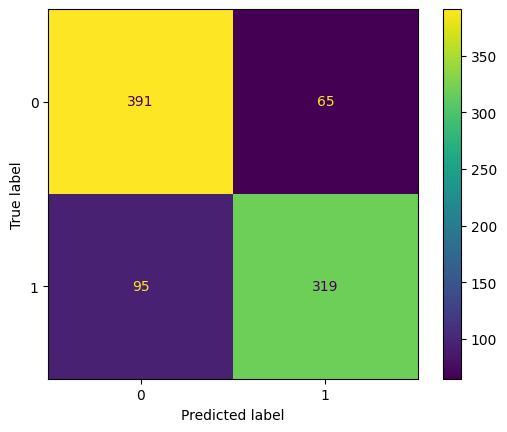

In [241]:
pred = gs["gradient_boosting"].predict(X_test_processed)
metric_class(y_test,pred)

## Gradient Boosting Won!

In [242]:
X_processed = preprocessing(X)

C:\Users\Hussain\AppData\Local\Temp\ipykernel_16904\2705686040.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dset["TotalSpent"].loc[slept_inx] = 0
C:\Users\Hussain\AppData\Local\Temp\ipykernel_16904\2705686040.py:32: SettingWithCopyWa

In [243]:
gs["gradient_boosting"].fit(X_processed,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=33, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-2,
             param_grid={'learning_rate': [0.1, 0.09, 0.07],
                         'n_estimators': [290, 300, 330]},
             scoring='accuracy')

In [246]:
gs["gradient_boosting"].best_params_

{'learning_rate': 0.09, 'n_estimators': 300}

In [247]:
sample = pd.read_csv("./Data/Origin/sample_submission.csv")

In [248]:
test = pd.read_csv("./Data/Origin/test.csv")
test_processed = preprocessing(test)

C:\Users\Hussain\AppData\Local\Temp\ipykernel_16904\2705686040.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dset["TotalSpent"].loc[slept_inx] = 0
C:\Users\Hussain\AppData\Local\Temp\ipykernel_16904\2705686040.py:32: SettingWithCopyWa

In [249]:
final_pred  = gs["gradient_boosting"].predict(test_processed)

In [250]:
sample["Transported"] = final_pred

In [252]:
sample.to_csv("./Result.csv",index=False)